In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline

import seaborn as sns

import pandas as pd
import numpy as np
import random
from copy import copy

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from sklearn.model_selection import train_test_split

In [7]:
SEED = 123 #used to help ra
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] 
LABELS = ["Normal","Break"]

In [12]:
df = pd.read_csv("train.csv",header=None) 
df.head(10)  # visualize the data.

,0,1,2
0,0.0001,-2.760010,0
1,0.0002,-2.855682,0
2,0.0003,-2.407379,0
3,0.0004,-3.140411,0
4,0.0005,-3.152466,0
5,0.0006,-2.641754,0
6,0.0007,-2.699280,0
7,0.0008,-2.593536,0
8,0.0009,-2.668152,0
9,0.0010,-2.758636,0


In [15]:
def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df[2].copy()
    
    sign = lambda x: (1, -1)[x < 0]
    
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        #print(tmp)
        tmp = tmp.fillna(0)
        vector += tmp
        
    labelcol = 2
    tmp=29
    # Add vector to the df
    df.insert(loc=0, column=labelcol+tmp, value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+tmp: labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [16]:
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df[2] == 1]
print(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(5))
#display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

Before shifting
           0         1  2
7227  0.7228 -2.538910  0
7228  0.7229 -2.588348  0
7229  0.7230 -2.932434  0
7230  0.7231 -2.002716  1
7231  0.7232 -1.266479  1


In [17]:
# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df_shift = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
print(df_shift.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(5))

After shifting
        2       0         1
7226  0.0  0.7227 -2.337494
7227  0.0  0.7228 -2.538910
7228  1.0  0.7229 -2.588348
7229  1.0  0.7230 -2.932434
7235  0.0  0.7236 -2.089081


In [20]:
input_X = df.loc[:, 1].values  # converts the df to a numpy array
input_X = input_X.reshape(-1, 1)
input_y = df[2].values
input_y = input_y.reshape(-1, 1)

n_features = input_X.shape[1]  # number of features

input_X.shape, input_y.shape

((99999, 1), (99999, 1))

In [21]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y

In [22]:
print('First instance of y = 1 in the original data')
print(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

First instance of y = 1 in the original data
       31      0         1   2 
7225  0.0  0.7226 -2.694397   0
7226  0.0  0.7227 -2.337494   0
7227  0.0  0.7228 -2.538910   0
7228  1.0  0.7229 -2.588348   0
7229  3.0  0.7230 -2.932434   0
7230  4.0  0.7231 -2.002716   1


In [23]:
lookback = 1  # Equivalent to 2ms of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
print(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))

For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.
          0
0 -2.002716


In [24]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT)

print(X_train.shape)

(63997, 1, 1, 1)


In [25]:
yy_train = np.reshape(y_train, (-1))
yy_valid = np.reshape(y_valid, (-1))
yy_test = np.reshape(y_test, (-1))

#inliers = X_train[np.where(y_train == 0)]
X_train_y0 = X_train[yy_train==0]
X_train_y1 = X_train[yy_train==1]
X_valid_y0 = X_valid[yy_valid==0]
X_valid_y1 = X_valid[yy_valid==1]

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
#numan1=flatten(X_train)
XX_train=copy(X_train)

X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [26]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
        
    return(flattened_X)

In [27]:
def scale(X, scaler):
    '''
    Scale 3D array.
    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [28]:
scaler = StandardScaler().fit(flatten(X_train_y0))

X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)


a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.]
colwise variance [1.]


In [29]:
#scale validation and test sets
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [31]:
#LSTM AE training:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 1

epochs = 30
batch = 64
lr = 0.0001

In [32]:
lstm_autoencoder = Sequential()
# Encoder it was originially 64//16
lstm_autoencoder.add(LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

In [33]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/30
976/976 - 14s - loss: 0.3972 - val_loss: 0.0279
Epoch 2/30
976/976 - 13s - loss: 0.0150 - val_loss: 0.0068
Epoch 3/30
976/976 - 12s - loss: 0.0043 - val_loss: 0.0024
Epoch 4/30
976/976 - 13s - loss: 0.0016 - val_loss: 0.0010
Epoch 5/30
976/976 - 13s - loss: 6.8441e-04 - val_loss: 4.9201e-04
Epoch 6/30
976/976 - 13s - loss: 3.2913e-04 - val_loss: 2.3904e-04
Epoch 7/30
976/976 - 13s - loss: 1.7025e-04 - val_loss: 1.7260e-04
Epoch 8/30
976/976 - 13s - loss: 9.2306e-05 - val_loss: 7.3152e-05
Epoch 9/30
976/976 - 13s - loss: 4.8558e-05 - val_loss: 4.0634e-05
Epoch 10/30
976/976 - 13s - loss: 2.9221e-05 - val_loss: 2.6808e-05
Epoch 11/30
976/976 - 12s - loss: 1.7673e-05 - val_loss: 1.8465e-05
Epoch 12/30
976/976 - 12s - loss: 1.0959e-05 - val_loss: 1.2178e-05
Epoch 13/30
976/976 - 12s - loss: 8.7514e-06 - val_loss: 8.1052e-06
Epoch 14/30
976/976 - 12s - loss: 6.6845e-06 - val_loss: 8.0212e-06
Epoch 15/30
976/976 - 12s - loss: 4.2220e-06 - val_loss: 4.2018e-06
Epoch 16/30
976/976 -

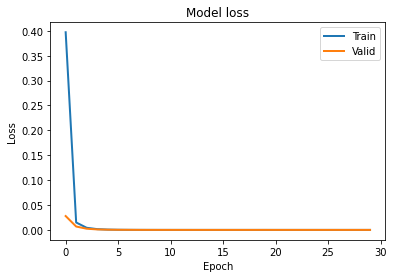

In [34]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

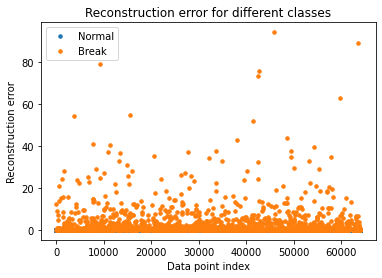

In [35]:
#valid data predictions using LSTM AE
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
x_train_df=df[1].copy()

mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': yy_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

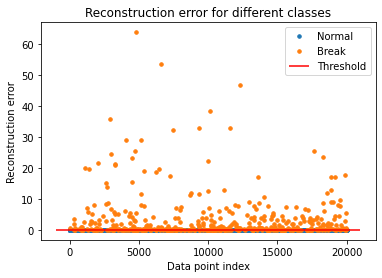

In [36]:
#test data predictions using LSTM AE
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': yy_test.tolist()})

threshold_fixed = 0.000001
#thresh = error_df.Reconstruction_error(np.where(error_df.True_class==1))

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

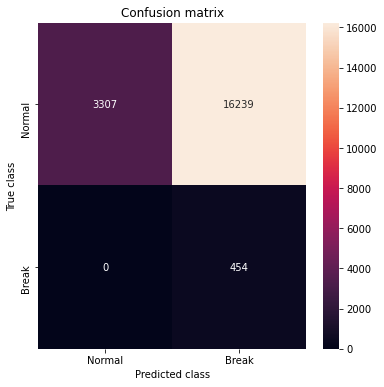

In [37]:
#confusion matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

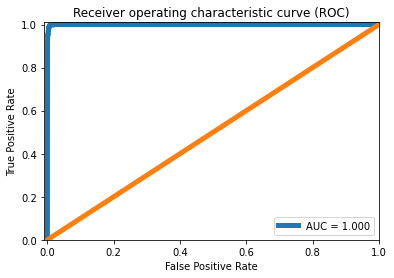

In [38]:
#ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()